# Real-Time Object Detection for Autonomous Vehicles

# KITTI → YOLOv8

## Install packages

In [9]:
!pip -q install \
  numpy==1.26.4 \
  pandas==2.2.2 \
  scipy==1.13.1 \
  matplotlib==3.8.0 \
  seaborn==0.13.2 \
  ultralytics opencv-python-headless pyyaml transformers accelerate --upgrade

## Setup paths and folders

In [10]:
import os, warnings, json, shutil, random, hashlib, time
from pathlib import Path
warnings.filterwarnings("ignore", category=FutureWarning)

# Disable WandB chatter
os.environ["WANDB_DISABLED"] = "true"
os.environ["WANDB_MODE"] = "offline"

PROJECT_ROOT = Path('/kaggle/working/kitti_phase1')
EXTRACT_DIR  = PROJECT_ROOT / 'kitti_extracted'
YOLO_DIR     = PROJECT_ROOT / 'kitti_yolo'
for d in [EXTRACT_DIR, YOLO_DIR]:
    d.mkdir(parents=True, exist_ok=True)

YOLO_IMAGES_TRAIN = YOLO_DIR / 'images' / 'train'
YOLO_LABELS_TRAIN = YOLO_DIR / 'labels' / 'train'
YOLO_IMAGES_VAL   = YOLO_DIR / 'images' / 'val'
YOLO_LABELS_VAL   = YOLO_DIR / 'labels' / 'val'
for d in [YOLO_IMAGES_TRAIN, YOLO_LABELS_TRAIN, YOLO_IMAGES_VAL, YOLO_LABELS_VAL]:
    d.mkdir(parents=True, exist_ok=True)

# KITTI base dataset
KAGGLE_KITTI = Path('/kaggle/input/kitti-dataset')
TRAIN_IMAGES_DIR = KAGGLE_KITTI / 'data_object_image_2' / 'training' / 'image_2'
TEST_IMAGES_DIR  = KAGGLE_KITTI / 'data_object_image_2' / 'testing' / 'image_2'
LABELS_DIR       = KAGGLE_KITTI / 'data_object_label_2' / 'training' / 'label_2'

# Optional YOLO-format labels dataset
YOLO_KITTI_DS   = Path('/kaggle/input/kitti-dataset-yolo-format')
YOLO_LABELS_ALT = YOLO_KITTI_DS / 'labels'
YOLO_CLASSES_ALT= YOLO_KITTI_DS / 'classes.json'

print('Train imgs:', len(list(TRAIN_IMAGES_DIR.glob('*.png'))))
print('Test  imgs:', len(list(TEST_IMAGES_DIR.glob('*.png'))))
print('KITTI label files:', len(list(LABELS_DIR.glob('*.txt'))))

Train imgs: 7481
Test  imgs: 7518
KITTI label files: 7481


## Pick route automatically

In [11]:
USE_READY_YOLO = YOLO_LABELS_ALT.exists() and YOLO_CLASSES_ALT.exists()
print('➡ Using ready YOLO-format labels dataset.' if USE_READY_YOLO else '➡ Converting KITTI labels to YOLO format with cleaning.')

➡ Converting KITTI labels to YOLO format with cleaning.


## Route A Use ready YOLO-format labels

In [12]:
from tqdm.auto import tqdm

if USE_READY_YOLO:
    with open(YOLO_CLASSES_ALT,'r') as f:
        CLASSES = json.load(f)
    CLASS_TO_ID = {c:i for i,c in enumerate(CLASSES)}

    ims = sorted(list(TRAIN_IMAGES_DIR.glob('*.png')))
    lbs = sorted(list(YOLO_LABELS_ALT.glob('*.txt')))
    label_set = {p.stem for p in lbs}
    pairs = [(im, YOLO_LABELS_ALT / f"{im.stem}.txt") for im in ims if im.stem in label_set]

    # manual 80/20 split (no sklearn)
    random.seed(42)
    random.shuffle(pairs)
    val_size = max(1, int(0.2 * len(pairs)))
    valid = pairs[:val_size]
    train = pairs[val_size:]

    for im, lb in tqdm(train, desc='Copy train'):
        shutil.copy2(im, YOLO_IMAGES_TRAIN / im.name)
        shutil.copy2(lb, YOLO_LABELS_TRAIN / lb.name)
    for im, lb in tqdm(valid, desc='Copy val'):
        shutil.copy2(im, YOLO_IMAGES_VAL / im.name)
        shutil.copy2(lb, YOLO_LABELS_VAL / lb.name)

## Route B — Convert KITTI → YOLO with cleaning & duplicate filtering

In [13]:
import cv2
from tqdm.auto import tqdm

def file_md5_resilient(path, chunk=1<<20, retries=3, pause=0.3):
    for attempt in range(1, retries+1):
        try:
            h = hashlib.md5()
            with open(path, 'rb') as f:
                while True:
                    data = f.read(chunk)
                    if not data: break
                    h.update(data)
            return h.hexdigest()
        except OSError:
            if attempt == retries: raise
            time.sleep(pause)

def convert_file_to_yolo(img_path, lbl_path, class_to_id):
    H, W = cv2.imread(str(img_path)).shape[:2]
    lines_out = []
    min_area_frac, max_area_frac, max_aspect = 1e-5, 0.8, 20.0
    with open(lbl_path) as f:
        for line in f:
            parts = line.split()
            if len(parts) < 8: continue
            cls = parts[0]
            if cls not in class_to_id: continue
            x1, y1, x2, y2 = map(float, parts[4:8])
            x1, y1 = max(0.0, x1), max(0.0, y1)
            x2, y2 = min(float(W-1), x2), min(float(H-1), y2)
            if x2 <= x1 or y2 <= y1: continue
            bw, bh = (x2-x1), (y2-y1)
            area_frac = (bw*bh)/(W*H)
            aspect = max(bw/max(bh,1e-6), bh/max(bw,1e-6))
            if area_frac < min_area_frac or area_frac > max_area_frac or aspect > max_aspect:
                continue
            xc = ((x1+x2)/2.0)/W
            yc = ((y1+y2)/2.0)/H
            w, h = bw/W, bh/H
            if w <= 0 or h <= 0: continue
            lines_out.append(f"{class_to_id[cls]} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")
    return lines_out

if not USE_READY_YOLO:
    CLASSES = ['Car', 'Pedestrian', 'Cyclist']
    CLASS_TO_ID = {c:i for i,c in enumerate(CLASSES)}

    images = sorted(TRAIN_IMAGES_DIR.glob('*.png'))
    labels = sorted(LABELS_DIR.glob('*.txt'))

    lbl_set = {p.stem for p in labels}
    imgs_without_lbl = [p for p in images if p.stem not in lbl_set]
    empty_label_files = [p for p in labels if p.stat().st_size == 0]

    valid_labels = {p.stem for p in labels if p.stat().st_size > 0}
    images = [p for p in images if p.stem in valid_labels]

    hash_seen, unique_images, dupe_images, unreadable_images = set(), [], [], []
    for p in images:
        try:
            h = file_md5_resilient(p)
            if h in hash_seen: dupe_images.append(p)
            else: hash_seen.add(h); unique_images.append(p)
        except OSError:
            unreadable_images.append(p)
    images = unique_images

    random.seed(42)
    usable_images = [p for p in images if (LABELS_DIR / (p.stem + '.txt')).exists()]
    random.shuffle(usable_images)
    split_idx = int(0.8 * len(usable_images))
    train_imgs, val_imgs = usable_images[:split_idx], usable_images[split_idx:]

    def process_split(img_paths, images_out_dir, labels_out_dir):
        kept, skipped = 0, 0
        for ip in tqdm(img_paths, desc=f"Convert {images_out_dir.parts[-2]}"):
            lp = LABELS_DIR / (ip.stem + '.txt')
            lines = convert_file_to_yolo(ip, lp, CLASS_TO_ID)
            if len(lines) == 0:
                skipped += 1
                continue
            shutil.copy2(ip, images_out_dir / ip.name)
            with open(labels_out_dir / (ip.stem + '.txt'), 'w') as f:
                f.write('\n'.join(lines) + '\n')
            kept += 1
        return kept, skipped

    kept_tr, skip_tr = process_split(train_imgs, YOLO_IMAGES_TRAIN, YOLO_LABELS_TRAIN)
    kept_va, skip_va = process_split(val_imgs,   YOLO_IMAGES_VAL,   YOLO_LABELS_VAL)

    CLEAN_REPORT = {
        'imgs_without_lbl':[p.name for p in imgs_without_lbl],
        'empty_label_files':[p.name for p in empty_label_files],
        'duplicate_images':[p.name for p in dupe_images],
        'unreadable_images':[p.name for p in unreadable_images],
        'train_kept': kept_tr, 'train_skipped': skip_tr,
        'val_kept': kept_va,   'val_skipped':  skip_va,
    }
    (PROJECT_ROOT / 'cleaning_report.json').write_text(json.dumps(CLEAN_REPORT, indent=2))

Convert images:   0%|          | 0/5984 [00:00<?, ?it/s]

Convert images:   0%|          | 0/1497 [00:00<?, ?it/s]

## Write `data.yaml`

In [14]:
import yaml
data_yaml = {
    'path': str(YOLO_DIR.resolve()),
    'train': 'images/train',
    'val':   'images/val',
    'names': CLASSES if 'CLASSES' in globals() else ['Car','Pedestrian','Cyclist'],
}
with open(YOLO_DIR / 'data.yaml', 'w') as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)
print((YOLO_DIR / 'data.yaml').read_text())

path: /kaggle/working/kitti_phase1/kitti_yolo
train: images/train
val: images/val
names:
- Car
- Pedestrian
- Cyclist



## Build labels DataFrame robustly

In [15]:
import pandas as pd, numpy as np, cv2

train_images = sorted((YOLO_DIR / 'images' / 'train').glob('*.png'))
train_labels = sorted((YOLO_DIR / 'labels' / 'train').glob('*.txt'))
val_images   = sorted((YOLO_DIR / 'images' / 'val').glob('*.png'))
val_labels   = sorted((YOLO_DIR / 'labels' / 'val').glob('*.txt'))

print('Train images:', len(train_images), 'Train labels:', len(train_labels))
print('Val images  :', len(val_images),   'Val labels  :', len(val_labels))

def parse_yolo_file(lbl_path, split_name):
    rows = []
    with open(lbl_path, 'r') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 5:
                continue
            cls_s, xc_s, yc_s, w_s, h_s = parts
            try:
                cls_i = int(cls_s)
                xc = float(xc_s); yc = float(yc_s); w = float(w_s); h = float(h_s)
            except Exception:
                continue
            if not all(map(np.isfinite, [xc, yc, w, h])):
                continue
            rows.append((split_name, lbl_path.stem + '.png', int(cls_i), float(xc), float(yc), float(w), float(h)))
    return rows

# Build columns explicitly (dict-of-lists)
cols = ["split","image","class_id","x_center","y_center","width","height"]
col_data = {c: [] for c in cols}
for lbl in train_labels:
    for tup in parse_yolo_file(lbl, 'train'):
        for c, v in zip(cols, tup):
            col_data[c].append(v)
for lbl in val_labels:
    for tup in parse_yolo_file(lbl, 'val'):
        for c, v in zip(cols, tup):
            col_data[c].append(v)

try:
    df = pd.DataFrame(col_data)
except Exception as e:
    print('Pandas unhappy, installing Polars as a bridge...', e)
    !pip -q install polars==1.7.1
    import polars as pl
    df = pl.DataFrame(col_data).to_pandas()

print('Dataset size:', len(df))
print('Unique images:', df['image'].nunique())
print('Class counts:\n', df['class_id'].value_counts())

Train images: 5984 Train labels: 5984
Val images  : 1497 Val labels  : 1497
Dataset size: 34842
Unique images: 7481
Class counts:
 class_id
0    28731
1     4484
2     1627
Name: count, dtype: int64


## Draw boxes helper

In [19]:
def show_image_with_bboxes(image_name, df, images_dir):
    p = Path(images_dir) / image_name
    img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape
    sub = df[df['image'] == image_name]
    for _, r in sub.iterrows():
        x, y, bw, bh = r['x_center'], r['y_center'], r['width'], r['height']
        x1 = int((x - bw/2) * w); y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w); y2 = int((y + bh/2) * h)
        cls = r['class_id']
        color = (0,255,0) if cls==0 else (255,0,0) if cls==1 else (0,0,255)
        label = 'Car' if cls==0 else 'Pedestrian' if cls==1 else 'Cyclist'
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches
        rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor=[c/255 for c in color], facecolor='none')
        plt.gca().add_patch(rect)
        plt.text(x1, y1-5, label, color='yellow', fontsize=9, bbox=dict(facecolor='black', alpha=0.5))
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,6)); plt.imshow(img); plt.axis('off'); plt.title(image_name); plt.show()

## Train YOLOv8 (quiet)

In [21]:
from ultralytics import YOLO
import torch, gc
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

data_cfg = str((YOLO_DIR / 'data.yaml').resolve())
project_dir = Path('/kaggle/working/yolov8n-kitti'); project_dir.mkdir(exist_ok=True)

model = YOLO('yolov8n.pt')
train_results = model.train(
    data=data_cfg,
    epochs=10,
    patience=3,
    imgsz=640,
    batch=8,
    workers=0,
    mixup=0.1,
    mosaic=0.6,
    device=0 if torch.cuda.is_available() else None,
    project=str(project_dir),
    name='train',
    verbose=False,
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/kitti_phase1/kitti_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False,

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  Tuple of RGBA values if X is scalar, otherwise an array of
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  Tuple of RGBA values if X is scalar, otherwise an array of


                   all       1497       6880      0.751      0.626      0.719      0.453
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to /kaggle/working/yolov8n-kitti/train


## Validate & show training plots

Ultralytics 8.3.203 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 4894.3±812.8 MB/s, size: 829.2 KB)
val: Scanning /kaggle/working/kitti_phase1/kitti_yolo/labels/val.cache... 1497 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1497/1497 3.2Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 188/188 7.2it/s 26.2s0.1ss


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  Tuple of RGBA values if X is scalar, otherwise an array of
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  Tuple of RGBA values if X is scalar, otherwise an array of


                   all       1497       6880      0.749      0.626      0.719      0.453
Speed: 0.1ms preprocess, 2.2ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to /kaggle/working/yolov8n-kitti/val


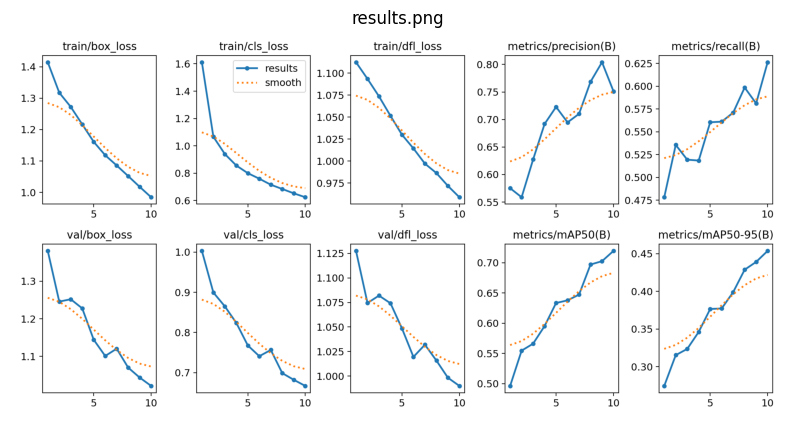

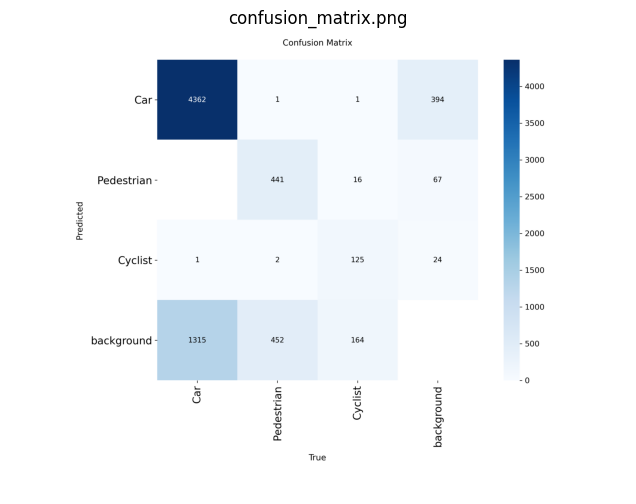

In [22]:
valid_results = model.val(project=str(project_dir), name='val', verbose=False)

from PIL import Image as PILImage
import matplotlib.pyplot as plt
plots = [project_dir/'train'/'results.png', project_dir/'train'/'confusion_matrix.png']
for p in plots:
    if p.exists():
        plt.figure(figsize=(10,6)); plt.imshow(PILImage.open(p)); plt.axis('off'); plt.title(p.name); plt.show()
    else:
        print('Missing plot:', p)

## Predictions on validation images (saved)

Results saved to /kaggle/working/yolov8n-kitti/pred4


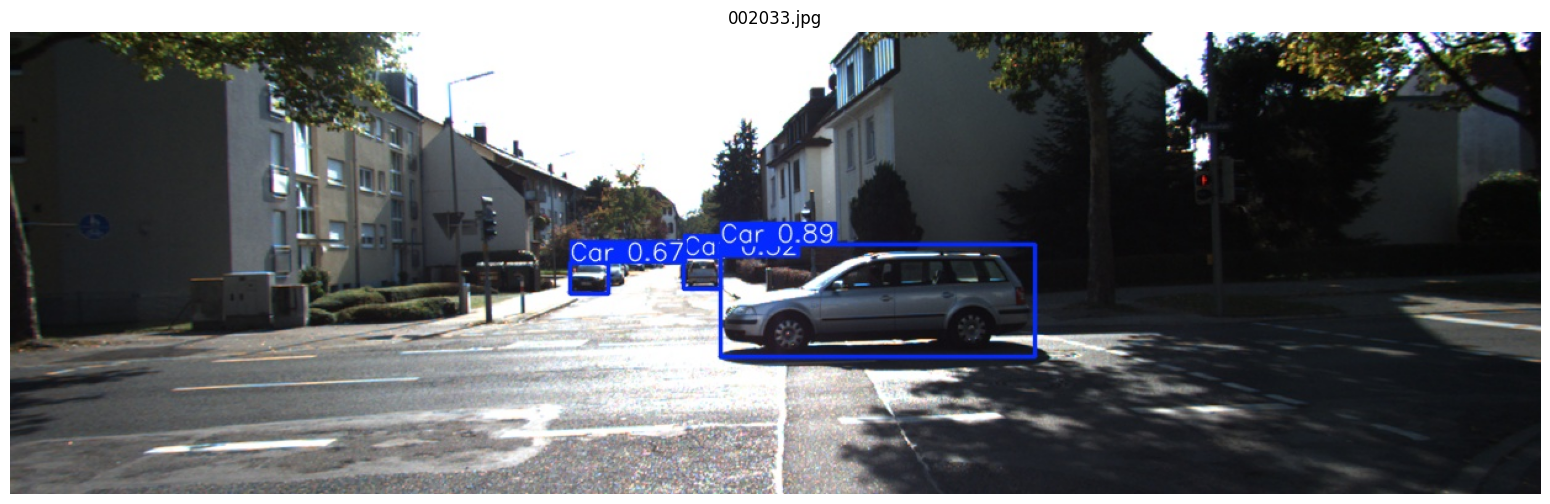

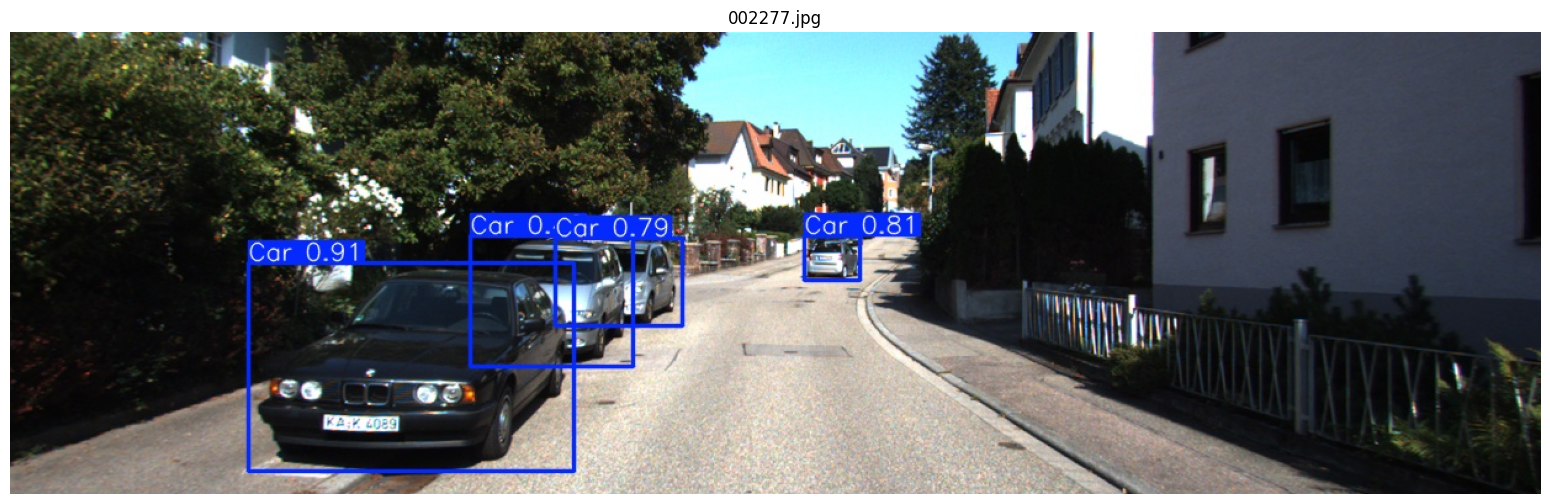

In [ ]:
val_imgs_list = sorted((YOLO_DIR / 'images' / 'val').glob('*.png'))
sample_paths = random.sample(val_imgs_list, min(10, len(val_imgs_list)))
preds = model.predict(sample_paths, save=True, project=str(project_dir), name='pred', verbose=False)

from PIL import Image as PILImage
import matplotlib.pyplot as plt
pred_dir = project_dir/'pred'
rendered = sorted(list(pred_dir.glob('*.jpg'))) or sorted(list(pred_dir.rglob('*.jpg')))
for p in rendered[:20]:
    plt.figure(figsize=(20,6)); plt.imshow(PILImage.open(p)); plt.axis('off'); plt.title(p.name); plt.show()

## GLPN Depth overlay with detections

E0000 00:00:1758663904.331469      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758663904.406687      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


preprocessor_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/245M [00:00<?, ?B/s]

Processing: 005977.png


model.safetensors:   0%|          | 0.00/245M [00:00<?, ?B/s]

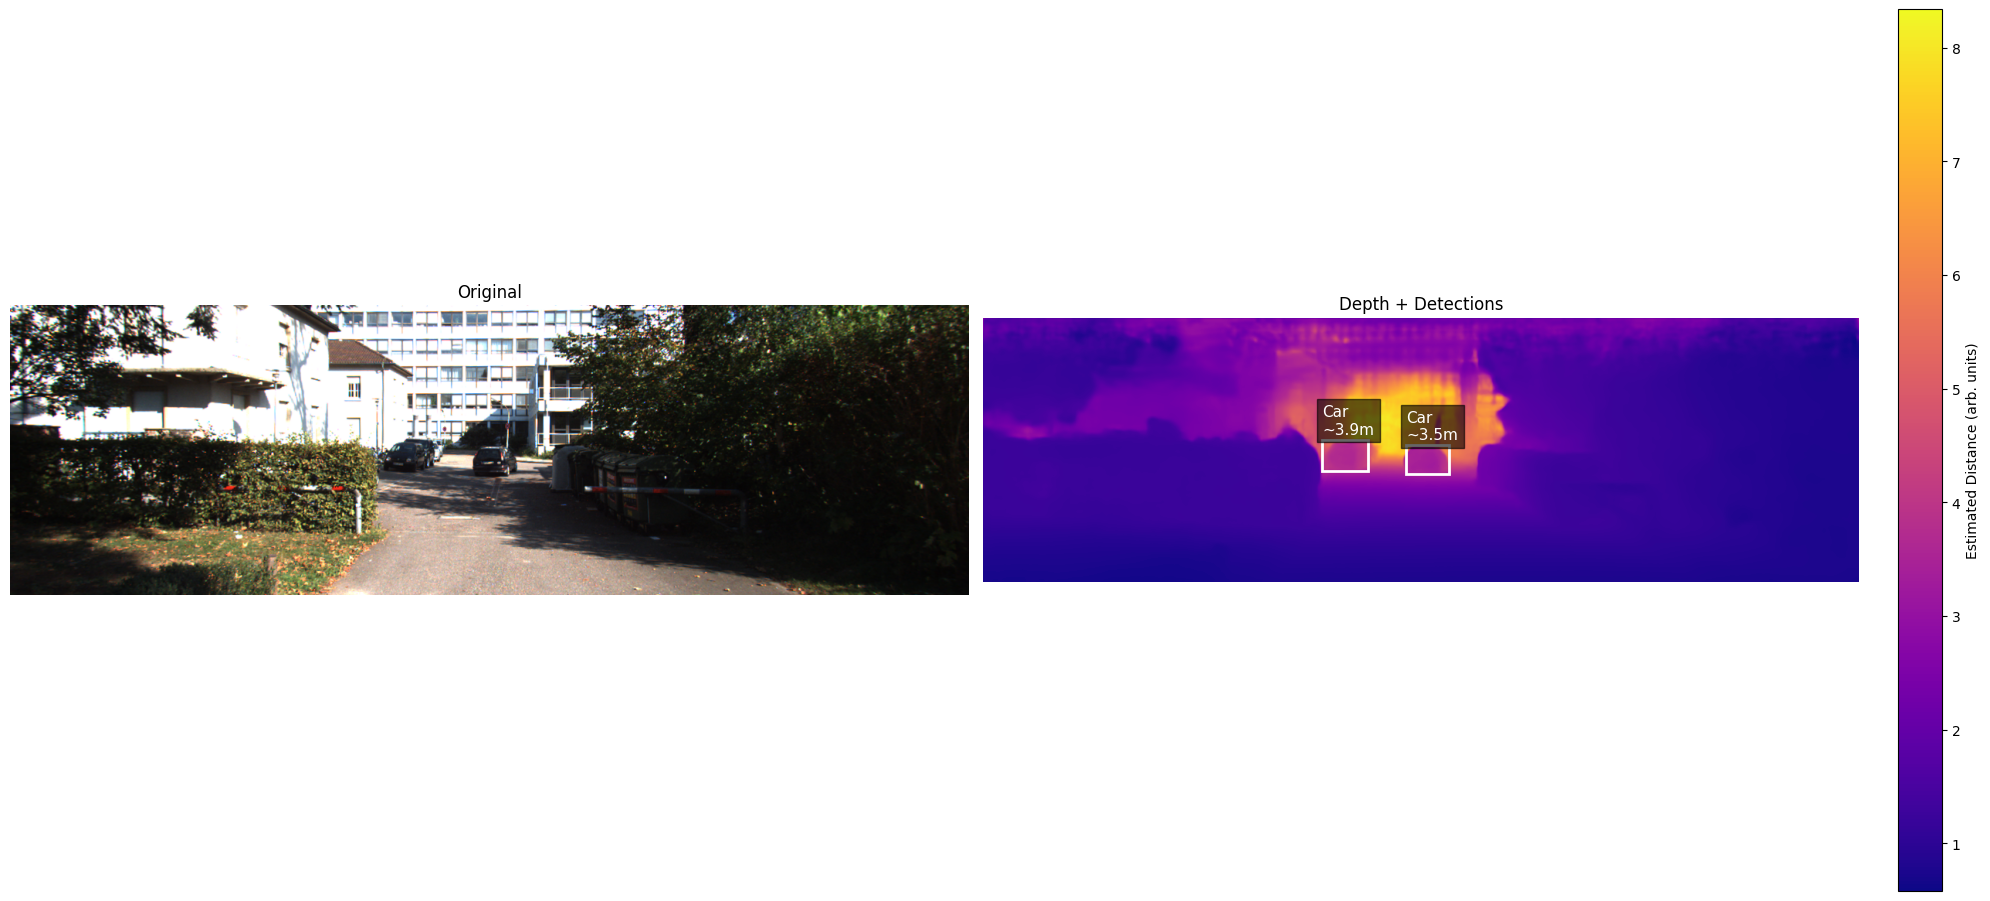

Processing: 004222.png


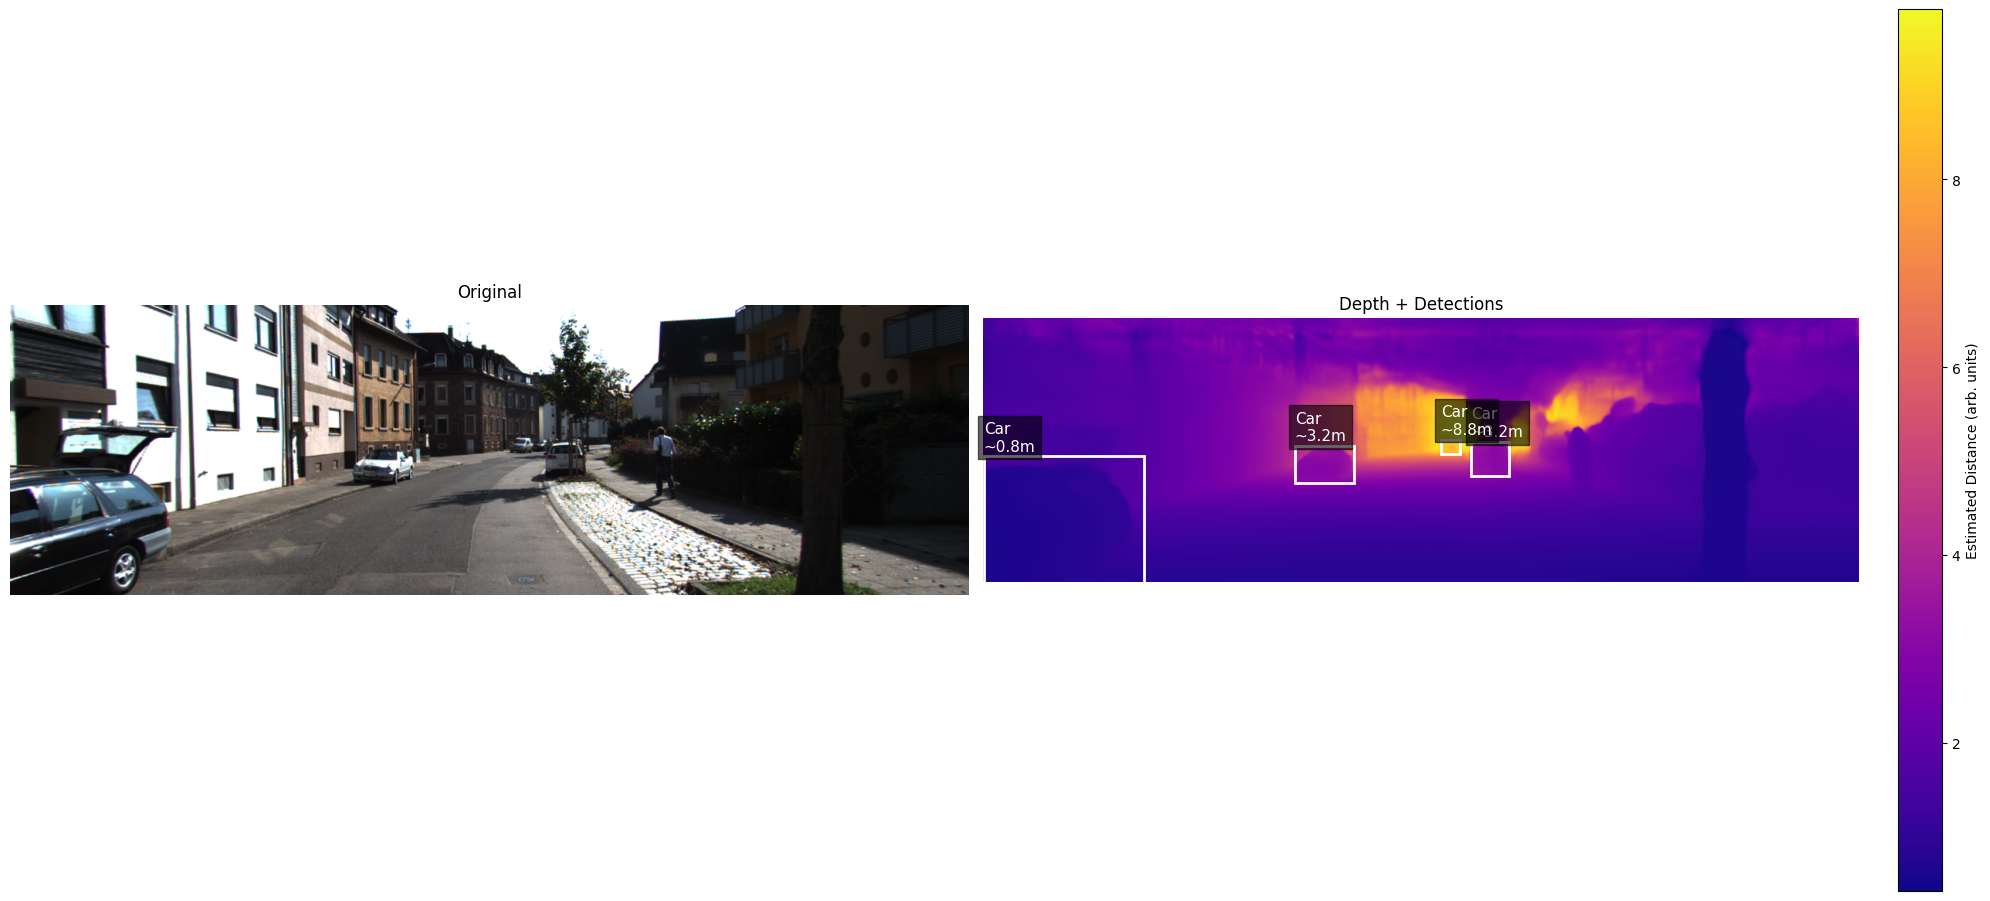

Processing: 002033.png


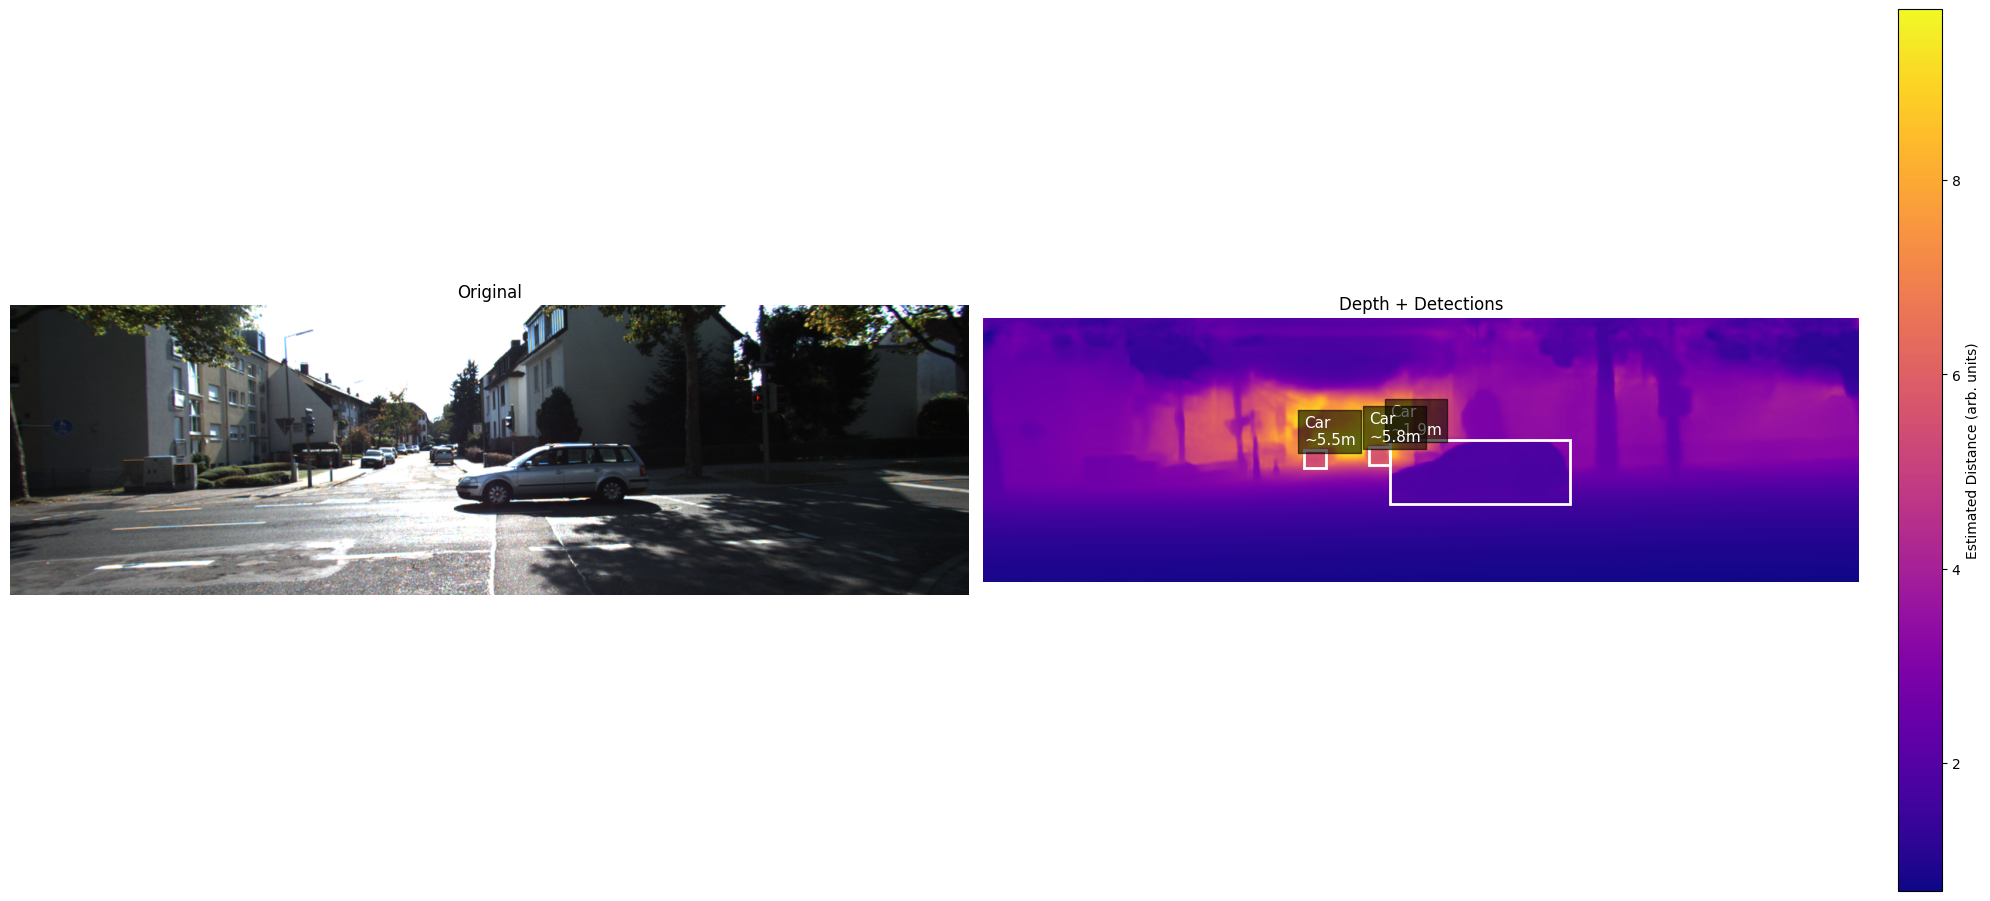

In [24]:
from transformers import GLPNImageProcessor, GLPNForDepthEstimation
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

best_pt = project_dir/'train'/'weights'/'best.pt'
yolo_model = YOLO(str(best_pt)) if best_pt.exists() else model

depth_processor = GLPNImageProcessor.from_pretrained('vinvino02/glpn-kitti')
depth_model = GLPNForDepthEstimation.from_pretrained('vinvino02/glpn-kitti')

def analyze_and_plot_image(image_path, yolo_model, depth_model, depth_processor):
    from PIL import Image as PILImage
    import torch
    image = PILImage.open(image_path).convert('RGB')
    yolo_results = yolo_model.predict(image_path, verbose=False)
    inputs = depth_processor(images=image, return_tensors='pt')
    with torch.no_grad():
        outputs = depth_model(**inputs)
        predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1), size=image.size[::-1], mode='bicubic', align_corners=False
    ).squeeze()
    depth_map = prediction.cpu().numpy()
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    axes[0].imshow(image); axes[0].set_title('Original'); axes[0].axis('off')
    im = axes[1].imshow(depth_map, cmap='plasma'); axes[1].set_title('Depth + Detections'); axes[1].axis('off')
    if len(yolo_results):
        res = yolo_results[0]
        for box in res.boxes:
            x1,y1,x2,y2 = box.xyxy[0].cpu().numpy().astype(int)
            cls = int(box.cls)
            name = res.names.get(cls, str(cls))
            obj_depth = depth_map[max(0,y1):max(0,y2), max(0,x1):max(0,x2)]
            med = np.median(obj_depth) if obj_depth.size>0 else 0.0
            rect = patches.Rectangle((x1,y1), x2-x1, y2-y1, linewidth=2, edgecolor='white', facecolor='none')
            axes[1].add_patch(rect)
            axes[1].text(x1, y1-8, f'{name}\n~{med:.1f}m', color='white', fontsize=11,
                         bbox=dict(facecolor='black', alpha=0.6))
    cbar = fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04)
    cbar.set_label('Estimated Distance (arb. units)')
    plt.tight_layout(); plt.show()

for p in sample_paths[:3]:
    print('Processing:', p.name)
    analyze_and_plot_image(str(p), yolo_model, depth_model, depth_processor)

In [25]:
SAFE_BEST = PROJECT_ROOT / 'best.pt'
if best_pt.exists():
    shutil.copy2(best_pt, SAFE_BEST)
    print('Saved best.pt ->', SAFE_BEST)
# Optional zip all results
# shutil.make_archive(str(PROJECT_ROOT/'yolov8n-kitti'), 'zip', root_dir=project_dir)
# print('Zipped:', (PROJECT_ROOT/'yol
    ov8n-kitti.zip').resolve())

Saved best.pt -> /kaggle/working/kitti_phase1/best.pt
